# Word Count using Pyspark

In this notebook I will conduct a basic analysis for texts: **Counting the occurence of words**, the number of total words and the number of different words. To do this in a scalable way I will use **pyspark**. In the last part a performance comparison is made for word count using pyspark and word count in the 'traditional' way not using pyspark.

The Moby Dick text file is available for free and can be downloaded for example here:
https://gist.github.com/StevenClontz/4445774

## 1. Calculation of the most common words

In [1]:
from pyspark import SparkContext
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
#Run spark on the local machine with as many threads as local cores on the machine
sc = SparkContext(master='local[*]')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ucsddse230/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%%time
text_raw = sc.textFile('mobydick.txt')
type(text_raw)

CPU times: user 1.93 ms, sys: 92 µs, total: 2.03 ms
Wall time: 1.13 s


In [3]:
%%time
#Using flatmap instead of map to get one list of all words instead of one list per line and make all words lowercase
words = text_raw.flatMap(lambda line: line.split(' ')).map(lambda x: x.lower())
#Filter out empty words
words_non_empty = words.filter(lambda x: x != '')
#Convert each word into a key value tuple in the form of (word, 1)
words_key_value = words_non_empty.map(lambda x: (x, 1))
#Using ReaduceByKey to count the occurence of each word
words_count = words_key_value.reduceByKey(lambda x,y: x+y)

CPU times: user 17.6 ms, sys: 3.49 ms, total: 21.1 ms
Wall time: 165 ms


In [4]:
#words_count.map(lambda x: (x[1], x[0])).sortByKey(ascending=False).take(20)
words_count_sorted = words_count.sortBy(lambda x: x[1], ascending=False)

In [5]:
#Get overview of how total number of words and the number of different words
total_words = words_count.map(lambda x: x[1]).reduce(lambda x,y: x+y)
different_words = words_count.count()
print('Total number of words: {} \nNumber of different words: {}'.format(total_words, different_words))

Total number of words: 115314 
Number of different words: 18637


In [6]:
#Display most common words
most_common_overall = words_count_sorted.take(20)
print('Most common words including stopwords')
print('word \t\tfrequency \n---------------------------')
[print('{}\t\t{}'.format(word, count)) for word, count in most_common_overall];

Most common words including stopwords
word 		frequency 
---------------------------
the		7018
of		3500
and		3155
a		2539
to		2375
in		2100
;		1949
that		1478
his		1317
i		1185
he		1019
it		1001
'		906
with		886
but		874
as		867
was		852
for		789
all		750
is		744


In [7]:
stopwords_extended = stopwords.words() + [';', "'", '!', '?', "'s", '"']
most_common_without_stopwords = words_count_sorted.filter(lambda x: x[0] not in stopwords_extended).take(20)
print('Most common words not including stopwords')
print('word \t\tfrequency \n---------------------------')
[print('{}\t\t{}'.format(word, count)) for word, count in most_common_without_stopwords];

Most common words not including stopwords
word 		frequency 
---------------------------
whale		298
upon		294
like		285
would		240
ye		221
old		202
though		193
moby-dick		192
said		171
captain		171
little		158
great		155
yet		152
ship		143
seemed		142
white		142
still		136
never		132
first		127
could		126


## 2.  Bar Chart

In the following a bar chart is used to see the spread of word frequencies.

<Figure size 1440x720 with 0 Axes>

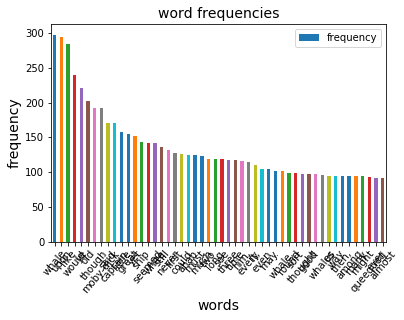

In [32]:
plt.figure(figsize=(20,10))
most_common_words_plot = words_count_sorted.filter(lambda x: x[0] not in stopwords_extended).take(50)
df = pd.DataFrame(most_common_words_plot, columns=['word', 'frequency'])
df.plot.bar(x='word', y='frequency')
plt.xticks(rotation=50)
plt.title('word frequencies', fontsize=14)
plt.xlabel('words', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

The bar chart shows that the first 5-10 words occur relatively often. The rest of the words occur with a similar frequency which is slightly decreasing. 

## 3. Word Cloud Visualization

In the following a word cloud visualization is applied, a common way to emphasize the most common words in texts.

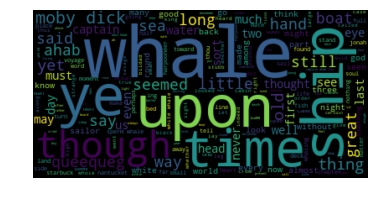

<Figure size 720x2160 with 0 Axes>

In [33]:
text_as_list = words_non_empty.filter(lambda x: x not in stopwords_extended).collect()
text_as_string = ' '.join(text_as_list)
wordcloud = WordCloud().generate(text_as_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(10,30))
plt.show()